In [1]:
# Load Packages
from Functions import *
# from sklearn.datasets import load_wine
# from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import time
import pickle
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
import libpysal
from esda.moran import Moran
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from itertools import combinations

# Set plot default
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams["axes.grid"] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("GPU is available.")
    device = torch.device("cuda")
else:
    print("GPU is not available.")
    device = torch.device("cpu")

GPU is available.


In [3]:
# Template to load synthetic dataset
df = pd.read_csv("High_Dim_Dataset_with_Target_rho_0.csv")
target = df.iloc[:,-1].values # response
df_scaled = df.iloc[:, :4].values # predictors

In [4]:
# Instantiate dataset customization class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], idx

In [5]:
# Instantiate AE class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
# Set Parameters for AE and format dataset to tensor via pytorch
dataset = CustomDataset(torch.tensor(df_scaled, dtype=torch.float32))
num_epochs = 10000
batch_size = 16
lr=0.001
input_dim = df_scaled.shape[1]
encoding_dim = 2
model = Autoencoder(input_dim, encoding_dim)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

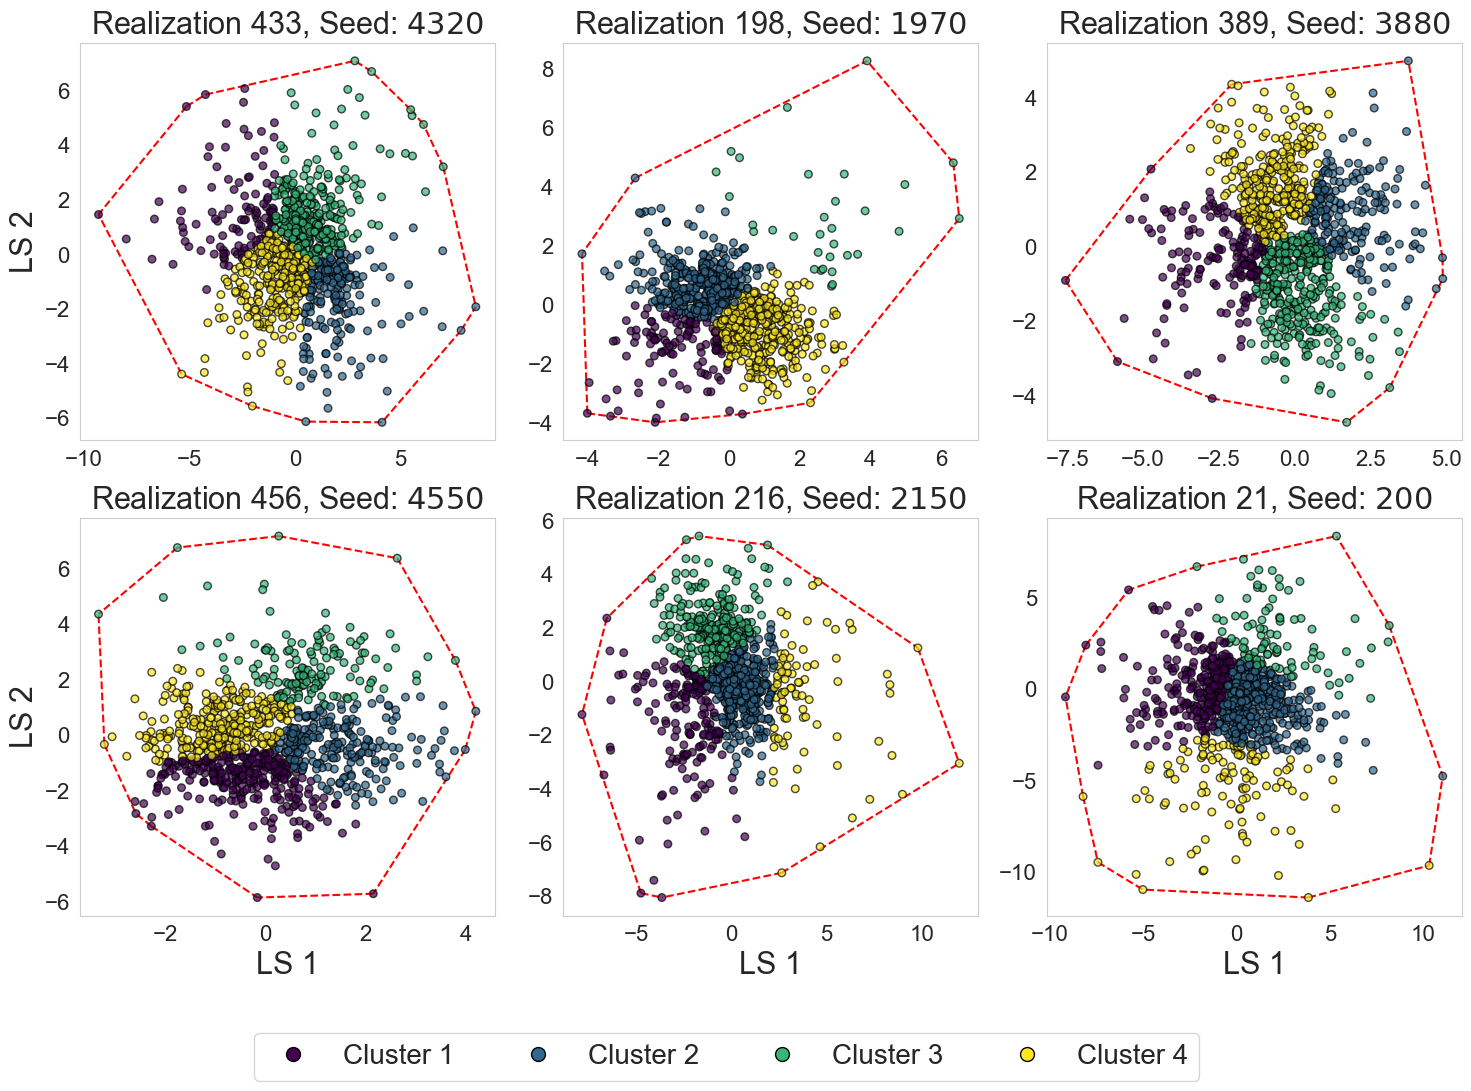

Total execution time: 520380.7074623108 seconds


In [7]:
# Time Tracker
start_time = time.time()

## Experiment Settings
# Random State/Seed Parameter Settings
num_seeds = num_realizations = 500 #1000
initial_seed = 0 # starting sequence for random seed generator
random.seed(initial_seed) # Initialize starting seed to ensure random seed sequence reproducibility
step_size = 10   # Change this to increase seeds every 'x' units as needed
seed_values = [initial_seed + (step_size * i) for i in range(num_seeds)] # sequence for selecting seeds used

# Variable Initialization to Store Results
cluster_changes = np.zeros_like(target)  # To track changes in cluster assignments
n_clusters = len(np.unique(target))  # nos of clusters in target if classification/ clustering problem
change_percentages = []  # List to store percentage of changed clusters for each realization
statistics_array = np.empty((num_seeds, 4)) # Array to store instability measures
convex_hull_vertices = [] # List to store convex hull vertices index for each realization
all_loss_curves = [] # MSE loss curves for each AE realizations
local_anisotropies = [] # List to store density dependent local anisotropies found within data
hdf5_file = 'embedding_realizations.h5' # store each latent space for all AE realizations here
with h5py.File(hdf5_file, 'w') as f: # Make the HDF5 file to store each AE realization latent space
    pass

# Make 3x3 subplot for 6 randomly selected AE realizations latent space visualizations
n_rows = 2
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axs = axs.ravel()
random.seed(initial_seed)
visualization_indices = random.sample(range(num_seeds), 6)

#   Fix ticks params in entire sublot
for ax in axs:
    ax.tick_params(axis='both', labelsize=16)

# Adding Y-axis labels to the first column
for ax in range(n_rows):
    axs[ax * n_cols].set_ylabel("LS 2", fontsize=22)

# Adding X-axis label to the bottom row
for ax in axs[n_cols:]:
    ax.set_xlabel("LS 1", fontsize=22)

# Run experiment
for idx, seed in enumerate(seed_values):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    #reset_environment(seed=seed)
    generator = torch.Generator().manual_seed(seed)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=generator)

    model = Autoencoder(input_dim, encoding_dim)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    epoch_losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        for data, indices in dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_losses.append(total_loss / len(dataloader))
    all_loss_curves.append(epoch_losses)

    # Reorder the embeddings gotten based on the originlal data index
    with torch.no_grad():
        encoded_data, original_indices = zip(*[(model.encoder(d[None, ...].to(device)), idx) for d, idx in dataset])
        # Reordering step here
        encoded_data = torch.cat(encoded_data, dim=0).cpu().numpy()
        order = np.argsort(original_indices)
        encoded_data = encoded_data[order]

        # Save each latent space embeddings to an HDF5 file
        with h5py.File(hdf5_file, 'a') as f:
            f.create_dataset(f'embedding_realizations_{idx}', data=encoded_data)

    # Perform clustering based on the number of clusters present in the response feature
    kmeans = KMeans(n_clusters=n_clusters, n_init=10).fit(encoded_data)
    predicted_clusters = kmeans.labels_

    # Matching predicted clusters to true clusters
    cost_matrix = -np.array([[np.sum((predicted_clusters[true_indices] == pred_cluster))
                              for pred_cluster in range(n_clusters)]
                             for true_indices in [np.where(target == i)[0] for i in range(n_clusters)]])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    for i in range(n_clusters):
        predicted_clusters[predicted_clusters == col_ind[i]] = -(i+10)  # Temporarily set to negative values
    for i in range(n_clusters):
        predicted_clusters[predicted_clusters == -(i+10)] = i

    changes = (predicted_clusters != target)
    change_percentages.append(100 * np.sum(changes) / len(target))
    cluster_changes += changes

    ## Compute statistics for each of the latent spaces for each AE realizations
    # Spatial
    weights = libpysal.weights.lat2W(encoded_data.shape[0],encoded_data.shape[1], rook=False, id_type="float")
    mi = Moran(encoded_data, weights)
    moran = mi.I

    # Anisotropy calcs
    mvee_anis= run_mvee(array_2d=encoded_data, plotter=False)
    global_anis, _, _ = compute_anisotropy(array_2d=encoded_data, type='global', plotter=False)
    _, local_anis, harmonic_anis = compute_anisotropy(array_2d=encoded_data, type='local', plotter=False)

    # Compute convex hull and associated attributes
    my_points = encoded_data.copy()
    hull = ConvexHull(my_points)
    vertices_idx = hull.vertices
    vertices = my_points[hull.vertices]
    polygon = Polygon(vertices)

    # Store the computed statistics
    statistics_array[idx, :] = [moran, mvee_anis, global_anis, harmonic_anis]
    local_anisotropies.append(np.array(local_anis))
    convex_hull_vertices.append(vertices_idx)

    # Check if the current realization index is in the list of visualization_indices
    if idx in visualization_indices:
        # Visualization of latent space in 3x3 grid
        scatter = axs[visualization_indices.index(idx)].scatter(encoded_data[:, 0], encoded_data[:, 1], c=predicted_clusters, cmap='viridis', marker='o', s=30,
                      alpha=0.7, edgecolor='black', zorder=2)
        axs[visualization_indices.index(idx)].set_title(f"Realization {idx + 1}, Seed: ${seed}$", fontsize=22)

        for simplex in hull.simplices:
            axs[visualization_indices.index(idx)].plot(my_points[simplex, 0], my_points[simplex, 1], 'r--', zorder=1)

        # Create colorbar based on the nos of clusters in target variable i.e., response feature
        n_clusters = len(np.unique(target))
        viridis = ListedColormap(plt.cm.viridis(np.linspace(0, 1, n_clusters)))

        # Create Line2D object for the legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {i+1}',
                                  markersize=10, markerfacecolor=viridis.colors[i], markeredgewidth=1, markeredgecolor='black') for i in range(n_clusters)]

# Save statistics to numpy files
np.save('statistics_array.npy', statistics_array)

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.10), ncol=n_clusters, fontsize=20)
plt.tight_layout()
plt.savefig('LS Visualization for Select AE Realizations with Convex Hull Line.tiff', dpi=300, bbox_inches='tight')
plt.show(block=False)

end_time = time.time()
total_time = end_time - start_time
print(f"Total execution time: {total_time} seconds")

In [8]:
# Save curated multiple lists from above to different file

with open('curated_lists.pkl', 'wb') as file:
    pickle.dump([all_loss_curves, change_percentages, convex_hull_vertices, local_anisotropies], file)

# # Load the data
#     with open('curated_lists.pkl', 'rb') as file:
#         all_loss_curves, change_percentages, convex_hull_vertices, local_anisotropies = pickle.load(file)

Visualize training loss for select AE realizations

The minimum loss for all AE realizations is:  0.10699


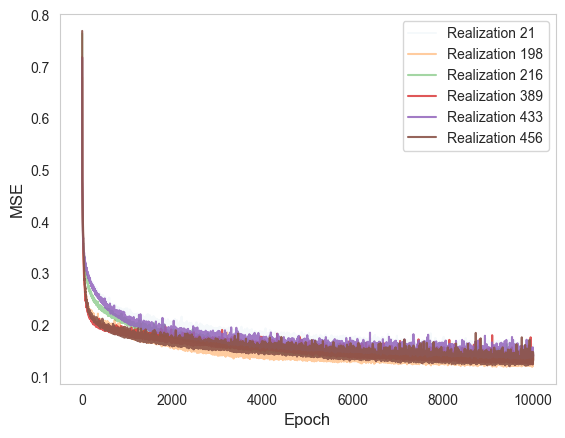

In [9]:
## Training Loss for Select AE Realizations over 10000 Epochs
loss_val = round(np.min(all_loss_curves),5)
print('The minimum loss for all AE realizations is: ',loss_val)

# Generate alpha values within the range [0, 1]
alphas = [i/num_seeds for i in range(1, num_seeds + 1)]

# Visualize loss functions for select realizations
for idx, losses in enumerate(all_loss_curves):
    if idx in visualization_indices:
        plt.plot(losses, label=f'Realization {idx+1}', alpha=alphas[idx])

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.legend()
plt.savefig('Training loss for select realizations.tiff', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Compute the percentage changes in anchors found via convex hull
change_anchors = percentage_change(convex_hull_vertices, data_type='list')

# Compute the percentage changes in Moran's
change_moran = percentage_change(statistics_array[:,0], data_type='numpy')

# Compute the percentage changes in anisotropies found
change_mvee_anis = percentage_change(statistics_array[:,1], data_type='numpy')
change_global_anis = percentage_change(statistics_array[:,2], data_type='numpy')
change_har_anis = percentage_change(statistics_array[:,3], data_type='numpy')

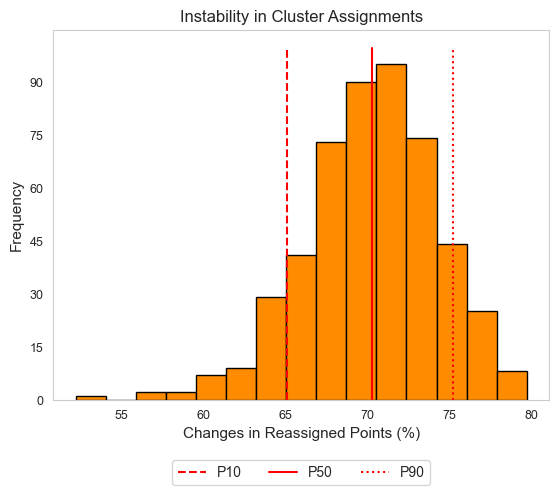

In [11]:
# Visualize changes in cluster assignement over all AE realizations
optimal_bin = knuth_bin_width(change_percentages)
plt.hist(change_percentages, bins=optimal_bin, color='darkorange', edgecolor='black')
histogram_bounds(ax_or_plt=plt, optimal_bin=optimal_bin, values=change_percentages, weights=np.ones(len(change_percentages)), color='red')
plt.xlabel('Changes in Reassigned Points (%)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Instability in Cluster Assignments')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(axis='both', labelsize=9)
plt.legend(loc='lower center', bbox_to_anchor=(0.50, -0.25), ncol=3)
plt.savefig('Instability in Cluster Assignemnts.tiff', dpi=300, bbox_inches='tight')
plt.show()

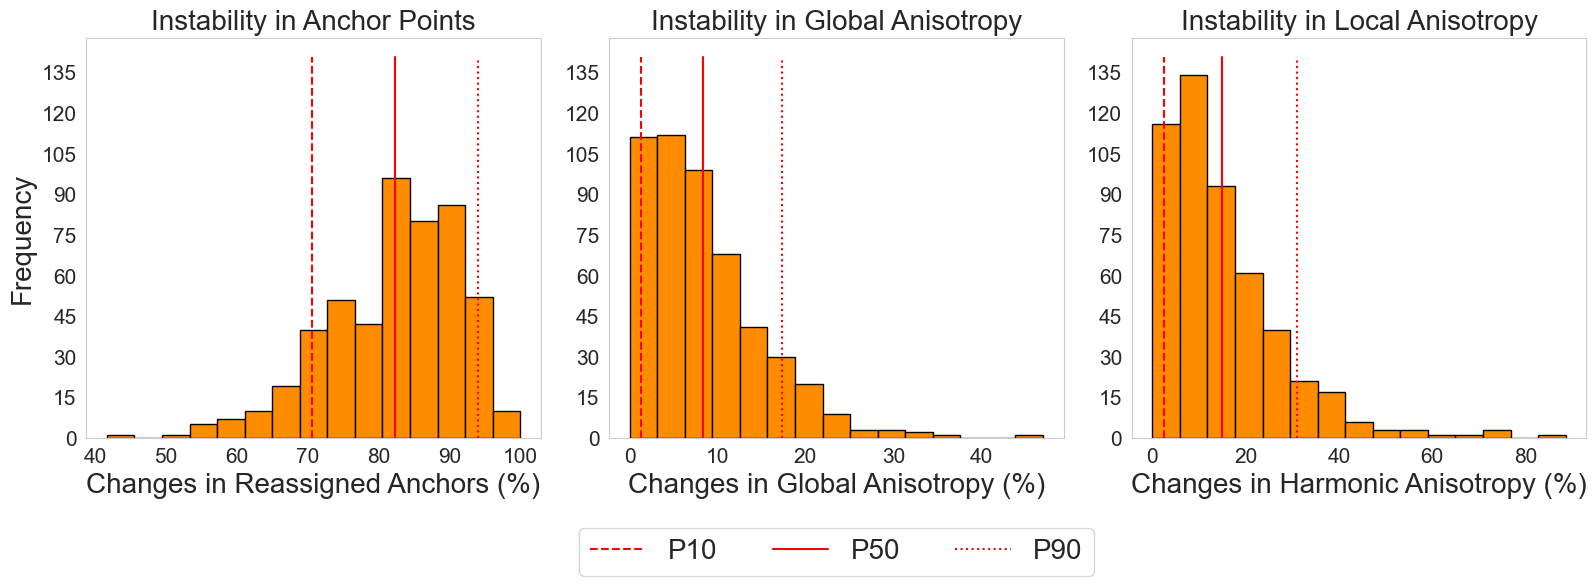

In [12]:
# Find optimal bins for each stats
optimal_bin1 = knuth_bin_width(change_anchors)
optimal_bin2 = knuth_bin_width(change_global_anis)
optimal_bin3 = knuth_bin_width(change_har_anis)

# Compute histogram data
hist_data_1, _ = np.histogram(change_anchors, bins=optimal_bin1)
hist_data_2, _ = np.histogram(change_global_anis, bins=optimal_bin2)
hist_data_3, _ = np.histogram(change_har_anis, bins=optimal_bin3)

# Obtain the maximum frequency from all histogram data since the sample size is same for each metric i.e. 1000 AE realizations
overall_max_freq = max(max(hist_data_1), max(hist_data_2), max(hist_data_3))
overall_max_freq += overall_max_freq * 0.05

# Visualize percentage changes for shape-based statistics
fig, axs = plt.subplots(1, 3, figsize=(10, 4)) #-o #8,4 ?
axs[0].hist(change_anchors, bins=optimal_bin1, color='darkorange', edgecolor='black')
histogram_bounds(ax_or_plt=axs[0], optimal_bin=optimal_bin1, values=change_anchors,weights=np.ones(len(change_anchors)), color='red', max_freq_override=overall_max_freq)
axs[0].set_xlabel('Changes in Reassigned Anchors (%)', fontsize= 20)
axs[0].set_ylabel('Frequency', fontsize= 20)
axs[0].set_title('Instability in Anchor Points', fontsize= 20)
axs[0].tick_params(axis='both', labelsize=15)
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].hist(change_global_anis, bins=optimal_bin2, color='darkorange', edgecolor='black')
histogram_bounds(ax_or_plt=axs[1], optimal_bin=optimal_bin2, values=change_global_anis,weights=np.ones(len(change_global_anis)),color='red', max_freq_override=overall_max_freq)
axs[1].set_xlabel('Changes in Global Anisotropy (%)', fontsize= 20)
axs[1].set_title('Instability in Global Anisotropy', fontsize= 20)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].tick_params(axis='both', labelsize=15)

axs[2].hist(change_har_anis, bins=optimal_bin3, color='darkorange', edgecolor='black') # based off F1 score computation INSPO!
histogram_bounds(ax_or_plt=axs[2], optimal_bin=optimal_bin, values=change_har_anis,weights=np.ones(len(change_har_anis)),color='red', max_freq_override=overall_max_freq)
axs[2].set_xlabel('Changes in Harmonic Anisotropy (%)', fontsize= 20)
axs[2].set_title('Instability in Local Anisotropy', fontsize= 20)
axs[2].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[2].tick_params(axis='both', labelsize=15)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:3], labels[:3], loc='lower center', bbox_to_anchor=(0.75, -0.08), ncol=3, fontsize=20)

plt.subplots_adjust(left=0.0, bottom=0.3, right=1.5, top=1.3, wspace=0.15, hspace=0.3)
plt.savefig('Instability in Shape-based Statistics.tiff', dpi=300, bbox_inches='tight')
plt.show()

## Stress and Jaccard Computations

In [14]:
# Stress computation for unique pairs only
with h5py.File(hdf5_file, 'r') as f:
    N = len(f.keys())
    # Initialize matrix
    adjusted_stress_matrix = np.zeros((N, N))

    for i in range(N):
        embedding_i = f[f'embedding_realizations_{i}'][:]
        for j in range(i + 1, N):  # Starting from i + 1 to avoid redundant computations
            embedding_j = f[f'embedding_realizations_{j}'][:]

            # Compute adjusted stress
            adj_stress = adjusted_stress(embedding_i, embedding_j)
            adjusted_stress_matrix[i, j] = adj_stress
            adjusted_stress_matrix[j, i] = adj_stress

# To compare the sets of vertices from the convex hulls across different realizations, let's use set operations.
# The idea is to assess the overlap and differences between the sets of indices for each pair of AE realizations
# and compute the Jaccard similarity.

comparisons = {}
for (i, vertices_i), (j, vertices_j) in combinations(enumerate(convex_hull_vertices), 2):
    set_i, set_j = set(vertices_i.tolist()), set(vertices_j.tolist())
    intersection = set_i.intersection(set_j)
    union = set_i.union(set_j)
    jaccard_similarity = len(intersection) / len(union) if union else 1
    comparisons[(i, j)] = jaccard_similarity

# Compute Jaccard similarity matrix
num_realizations = len(convex_hull_vertices)
similarity_matrix = np.zeros((num_realizations, num_realizations))

for (i, j), similarity in comparisons.items():
    similarity_matrix[i, j] = similarity
    similarity_matrix[j, i] = similarity  # Mirror the similarity as the matrix is symmetric

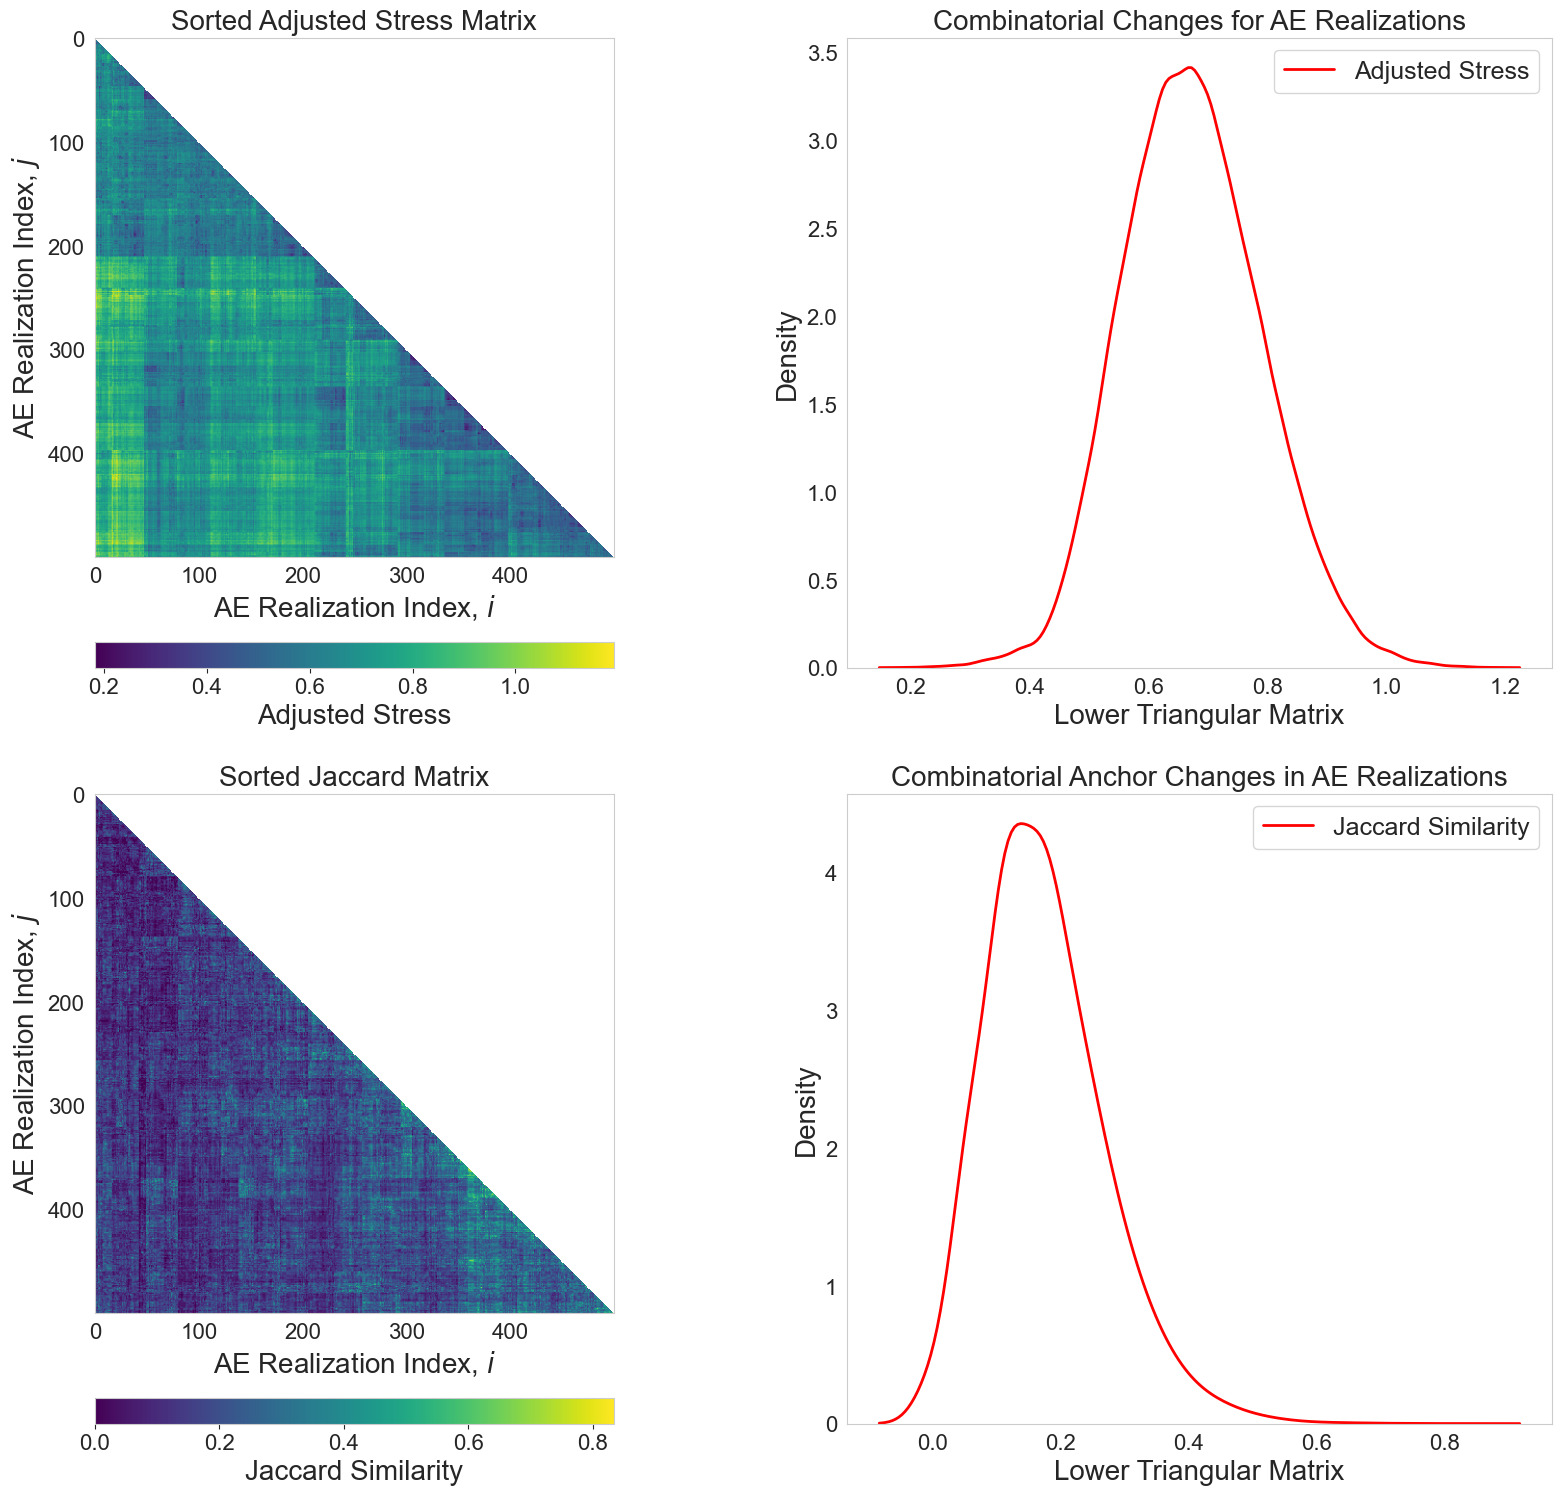

In [36]:
# Compute and Visualize stress measures
ordered_dist_mat1, res_order1, res_linkage1 = compute_serial_matrix(adjusted_stress_matrix,"ward")

# Extract the lower triangular matrix for the sorted stress matrices excluding diagonal and visualize via kde
lower_triangle1 = np.tril(ordered_dist_mat1, k=-1) # Adjusted stress
upper_triangle_mask = np.triu(np.ones(ordered_dist_mat1.shape), k=0).astype(bool)
lower_triangle1[upper_triangle_mask] = np.nan
flatten_data1 = lower_triangle1[~np.isnan(lower_triangle1)]

# Compute and Visualize Jaccard similarity measures
ordered_dist_mat2, res_order2, res_linkage2 = compute_serial_matrix(similarity_matrix,"ward")

# Extract the lower triangular matrix for the sorted stress matrices excluding diagonal and visualize via kde
lower_triangle2 = np.tril(ordered_dist_mat2, k=-1) # Jaccard similarity
upper_triangle_mask = np.triu(np.ones(ordered_dist_mat2.shape), k=0).astype(bool)
lower_triangle2[upper_triangle_mask] = np.nan
flatten_data2 = lower_triangle2[~np.isnan(lower_triangle2)]

# Save stress and jaccard values to numpy arrays
np.save('jaccard_array_corr_0.npy', flatten_data2)
# np.save('jaccard_array_wine.npy', flatten_data2)
# np.save('jaccard_array_corr_1.npy', flatten_data2)

np.save('stress_array_corr_0.npy', flatten_data1)
# np.save('stress_array_wine.npy', flatten_data1)
# np.save('stress_array_corr_1.npy', flatten_data1)

fig, axs = plt.subplots(2, 2, figsize=(20, 18)) # orange and purple
# Sorted Adjusted Stress - lower triangle matrix excluding diagonal
im1 = axs[0, 0].imshow(lower_triangle1, cmap="viridis")
axs[0, 0].set_title("Sorted Adjusted Stress Matrix", size=20)
axs[0, 0].set_xlabel("AE Realization Index, $i$", size=20)
axs[0, 0].set_ylabel("AE Realization Index, $j$", size=20)
axs[0, 0].tick_params(axis='both', which='major', labelsize=16)
# Aesthetics
divider = make_axes_locatable(axs[0, 0])
cax1 = divider.append_axes("bottom", size="5%", pad=0.85)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.25)
cbar1.set_label('Adjusted Stress', size=20)
cbar1.ax.tick_params(labelsize=16)

# KDE of lower triangular matrix of adjusted stress excluding the diagonal
sns.kdeplot(flatten_data1, ax=axs[0, 1], color='red', label='Adjusted Stress', linewidth=2)
axs[0, 1].set_title("Combinatorial Changes for AE Realizations", size=20)
axs[0, 1].set_xlabel('Lower Triangular Matrix', fontsize=20)
axs[0, 1].set_ylabel('Density', fontsize=20)
axs[0, 1].tick_params(labelsize=16)
axs[0, 1].legend(fontsize=18)

# Sorted Adjusted Jaccard - lower triangle matrix excluding diagonal
im1 = axs[1, 0].imshow(lower_triangle2, cmap="viridis")
axs[1, 0].set_title("Sorted Jaccard Matrix", size=20)
axs[1, 0].set_xlabel("AE Realization Index, $i$", size=20)
axs[1, 0].set_ylabel("AE Realization Index, $j$", size=20)
axs[1, 0].tick_params(axis='both', which='major', labelsize=16)
# Aesthetics
divider = make_axes_locatable(axs[1, 0])
cax1 = divider.append_axes("bottom", size="5%", pad=0.85)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.25)
cbar1.set_label('Jaccard Similarity', size=20)
cbar1.ax.tick_params(labelsize=16)

# KDE of lower triangular matrix of Jaccard excluding the diagonal
sns.kdeplot(flatten_data2, ax=axs[1, 1], bw_method=0.3, color='red', label='Jaccard Similarity', linewidth=2)
axs[1, 1].set_title("Combinatorial Anchor Changes in AE Realizations", size=20) 
axs[1, 1].set_xlabel('Lower Triangular Matrix', fontsize=20)
axs[1, 1].set_ylabel('Density', fontsize=20)
axs[1, 1].tick_params(labelsize=16)
axs[1, 1].legend(fontsize=18)

# Customization
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig('Combined Stress and Jaccard Analysis.tiff', dpi=300, bbox_inches='tight')
plt.show()

## Analyze Statistics

In [16]:
# Extract local anisotropies
max_length = max(len(arr) for arr in local_anisotropies) # also yields the max number of arrays that the original list is seperated into
element_arrays = [np.array([arr[i] if i < len(arr) else np.nan for arr in local_anisotropies]) for i in range(max_length)]

print(max_length)

3


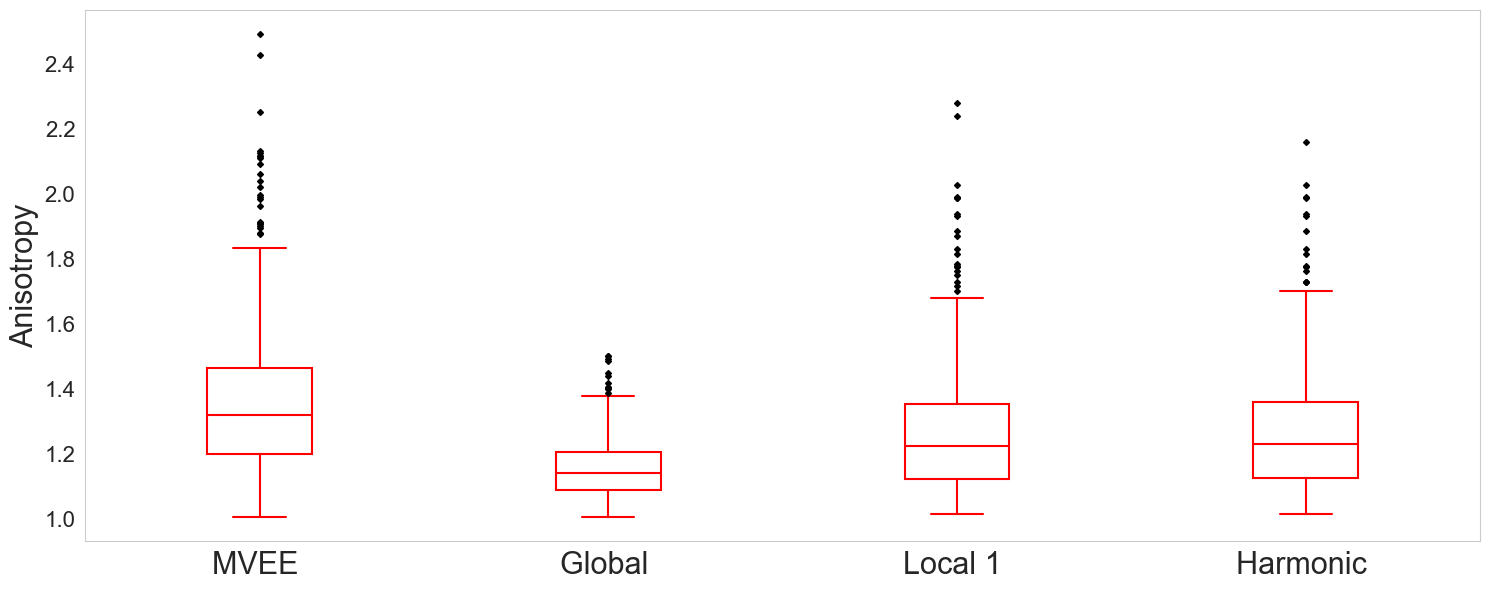

In [19]:
# Visualize Anisotropy alongside types of local that exist too
anisotropy_dict = {
              'MVEE ': statistics_array[:,1],
              'Global ': statistics_array[:,2],
              'Local 1 ': element_arrays[0],
              # 'Local 2 ': element_arrays[1],
              # 'Local 3 ': element_arrays[2],
              'Harmonic ': statistics_array[:,3]
              }

make_boxplot(dictionary=anisotropy_dict, y_label="Anisotropy", box_width=0.3, c_str='red')
# make_boxplot(dictionary=anisotropy_dict, y_label="Anisotropy", box_width=0.3, c_str='blue')
# make_boxplot(dictionary=anisotropy_dict, y_label="Anisotropy", box_width=0.3, c_str='green')


# box_plot(dictionary=anisotropy_dict, var_name='Anisotropies', value_name='Anisotropy', save_title='Anisotropy measures for all AE realizations', xlabel_rot=45)

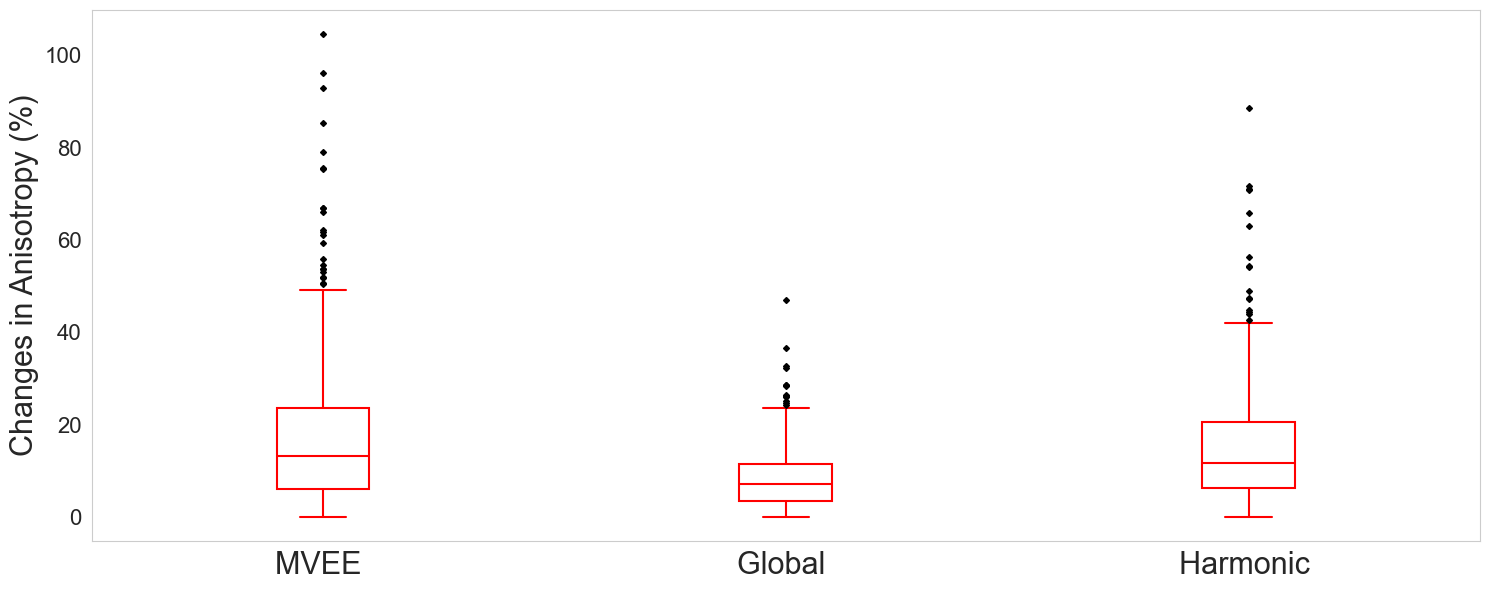

In [20]:
# Visualize major anisotropy stats
change_anisotropy_dict = {
              'MVEE ': np.array(change_mvee_anis),
              'Global ': np.array(change_global_anis),
              'Harmonic ': np.array(change_har_anis)
              }

make_boxplot(dictionary=change_anisotropy_dict, y_label="Changes in Anisotropy (%)", box_width=0.2, c_str='red')
# make_boxplot(dictionary=change_anisotropy_dict, y_label="Changes in Anisotropy (%)", box_width=0.2, c_str='blue')
# make_boxplot(dictionary=change_anisotropy_dict, y_label="Changes in Anisotropy (%)", box_width=0.2, c_str='green')


# box_plot(dictionary=change_anisotropy_dict, var_name='Anisotropies', value_name='Changes in Anisotropy (%)', save_title='Change in Anisotropy measures for all AE realizations')

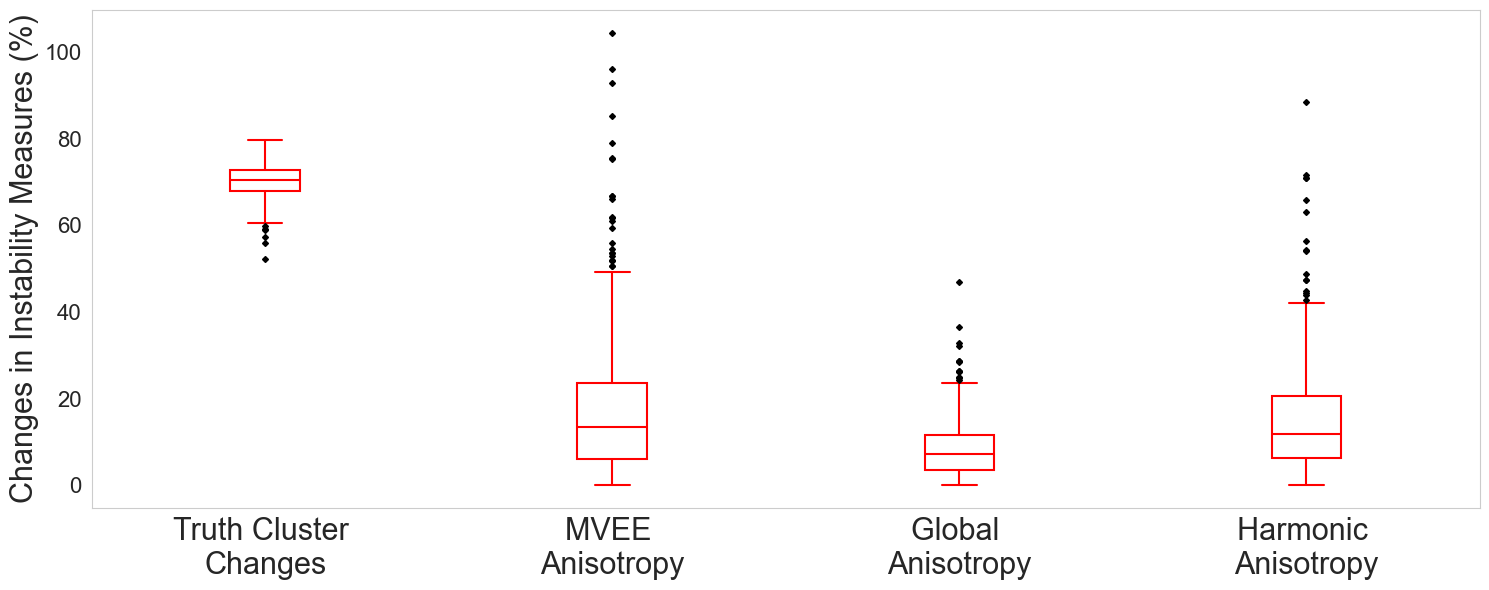

In [22]:
# Visualize changes in instability measures
instability_measures_corr_0= {
# instability_measures_wine= {
# instability_measures_corr_1= {
              # 'Anchors \nChanges': np.array(change_anchors),
              'Truth Cluster \nChanges': np.array(change_percentages),
              'MVEE \nAnisotropy': np.array(change_mvee_anis),
              'Global \nAnisotropy': np.array(change_global_anis),
              'Harmonic \nAnisotropy': np.array(change_har_anis),
              }

make_boxplot(dictionary=instability_measures_corr_0, y_label="Changes in Instability Measures (%)", box_width=0.2, c_str='red')
# make_boxplot(dictionary=instability_measures_wine, y_label="Changes in Instability Measures (%)", box_width=0.2, c_str='blue')
# make_boxplot(dictionary=instability_measures_corr_1, y_label="Changes in Instability Measures (%)", box_width=0.2, c_str='green')


# box_plot(dictionary=instability_measures_corr_1, var_name='Reassignments', value_name='Changes in Instability Measures (%)', save_title='Change in Instability measures for all AE realizations', box_width=0.6, xlabel_rot=45)

In [23]:
# Visualize instability on a data point basis across multiple latent spaces for the same data index
# Function to normalize data using Min-Max scaling to the range [0, 1]
def min_max_scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# User-specified indices
#selected_indices = [] insert index of interest
selected_indices = list(range(0, 1000))

# Process the user-specified indices in the first column
with h5py.File(hdf5_file, 'r') as file:
    # Normalize each dataset on [0, 1] since they are in same order already
    normalized_datasets = {key: min_max_scale(file[key][:]) for key in file.keys()}

    for i in selected_indices:
        ith_elements = [normalized_datasets[key][i, 0] for key in file.keys()]
        ith_elements_array = np.array(ith_elements)

        # Make figure for each histogram
        fig, ax = plt.subplots(figsize=(5, 4))
        optimal_bin_i = knuth_bin_width(ith_elements_array)
        ax.hist(ith_elements_array, bins=optimal_bin_i, color='red')
        ax.set_title(f'Data Index {i}')
        ax.set_xlabel('Normalized Value in LS 1')
        ax.set_ylabel('Frequency')
        ax.set_xlim([0, 1]) 
        plt.tight_layout()

        plt.savefig(f'Data Index {i} Visualization as Histogram.tiff', dpi=300, bbox_inches='tight')
        plt.close(fig)

In [24]:
# Save pickled instability measures and other metrics for each case/scenario to file
pickle_file1 = 'instability_measures_corr_0.pkl'
with open(pickle_file1, 'wb') as file:
    pickle.dump(instability_measures_corr_0, file)

# pickle_file2 = 'instability_measures_wine.pkl'
# with open(pickle_file2, 'wb') as file:
#     pickle.dump(instability_measures_wine, file)

# pickle_file3 = 'instability_measures_corr_1.pkl'
# with open(pickle_file3, 'wb') as file:
#     pickle.dump(instability_measures_corr_1, file)

## Latent Space Anisotropy Visualizations

For correlation = 0, visualize realization index 199 for bimodal local anisotropy computation

In [25]:
# Extract embedding at idx 199 since it is examplary for the case of multiple local anisotropy that differs from global anisotropy
with h5py.File(hdf5_file, 'r') as f:
    key = f'embedding_realizations_199'
    if key in f:
        example_embedding = f[key][:]

    else:
        print(f"Key '{key}' not found in the HDF5 file.")

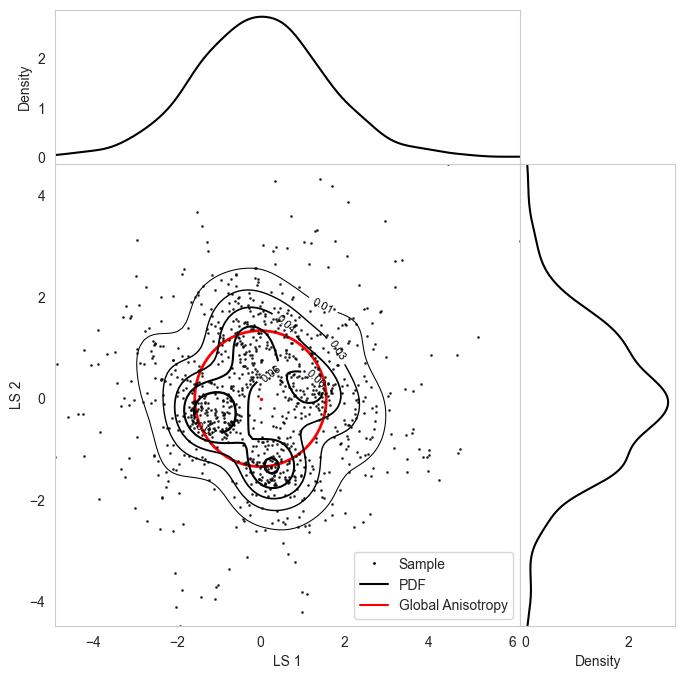

1.1707886228719693


In [26]:
global_anis, local_anis, harmonic_anis = compute_anisotropy(array_2d=example_embedding, type='global', plotter=True)
print(global_anis)

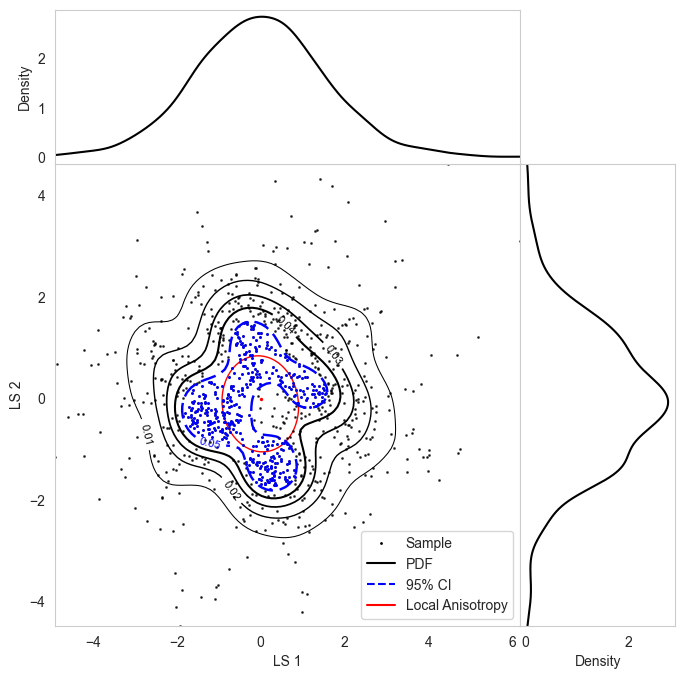

[1.069899531952439] 1.069899531952439


In [27]:
global_anis, local_anis, harmonic_anis = compute_anisotropy(array_2d=example_embedding, type='local', plotter=True)
print(local_anis, harmonic_anis)

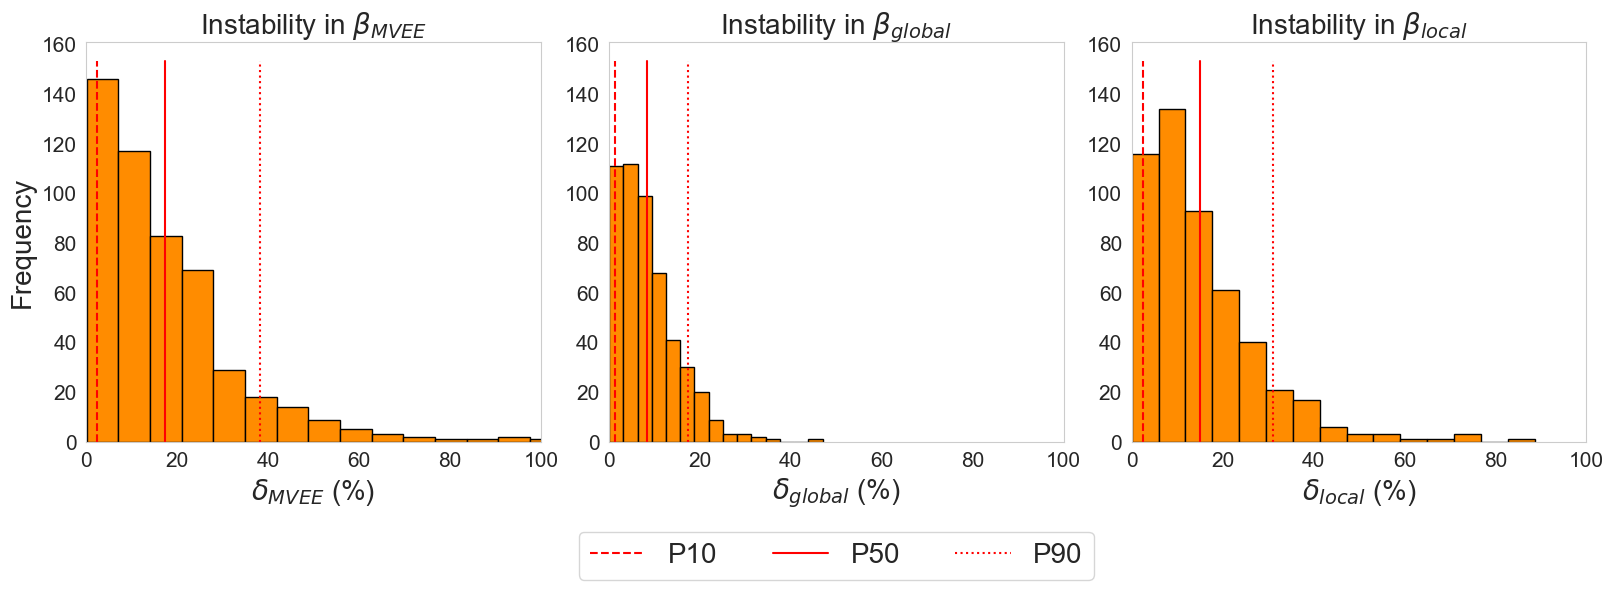

In [189]:
# Find optimal bins for each stats
optimal_bin1 = knuth_bin_width(change_mvee_anis)
optimal_bin2 = knuth_bin_width(change_global_anis)
optimal_bin3 = knuth_bin_width(change_har_anis)

# Compute histogram data
hist_data_1, _ = np.histogram(change_mvee_anis, bins=optimal_bin1)
hist_data_2, _ = np.histogram(change_global_anis, bins=optimal_bin2)
hist_data_3, _ = np.histogram(change_har_anis, bins=optimal_bin3)

# Obtain the maximum frequency from all histogram data since the sample size is same for each metric i.e. 1000 AE realizations
overall_max_freq = max(max(hist_data_1), max(hist_data_2), max(hist_data_3))
overall_max_freq += overall_max_freq * 0.05

# Visualize percentage changes for shape-based statistics
fig, axs = plt.subplots(1, 3, figsize=(10, 4)) #-o #8,4 ?
axs[0].hist(change_mvee_anis, bins=optimal_bin1, color='darkorange', edgecolor='black')
histogram_bounds(ax_or_plt=axs[0], optimal_bin=optimal_bin1, values=change_mvee_anis,weights=np.ones(len(change_mvee_anis)), color='red', max_freq_override=overall_max_freq)
axs[0].set_xlabel(r'$\delta_{MVEE}$ (%)', fontsize= 20)
axs[0].set_ylabel('Frequency', fontsize= 20)
axs[0].set_title("Instability in $\\beta_{MVEE}$", fontsize= 20)
axs[0].tick_params(axis='both', labelsize=15)
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[0].set_xlim([0, 100])  # Set x-axis limits

axs[1].hist(change_global_anis, bins=optimal_bin2, color='darkorange', edgecolor='black')
histogram_bounds(ax_or_plt=axs[1], optimal_bin=optimal_bin2, values=change_global_anis,weights=np.ones(len(change_global_anis)),color='red', max_freq_override=overall_max_freq)
axs[1].set_xlabel(r'$\delta_{global}$ (%)', fontsize= 20)
axs[1].set_title("Instability in $\\beta_{global}$", fontsize= 20)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].tick_params(axis='both', labelsize=15)
axs[1].set_xlim([0, 100])  # Set x-axis limits

axs[2].hist(change_har_anis, bins=optimal_bin3, color='darkorange', edgecolor='black') # based off F1 score computation INSPO!
histogram_bounds(ax_or_plt=axs[2], optimal_bin=optimal_bin, values=change_har_anis,weights=np.ones(len(change_har_anis)),color='red', max_freq_override=overall_max_freq)
axs[2].set_xlabel(r'$\delta_{local}$ (%)', fontsize= 20)
axs[2].set_title("Instability in $\\beta_{local}$", fontsize= 20)
axs[2].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[2].tick_params(axis='both', labelsize=15)
axs[2].set_xlim([0, 100])  # Set x-axis limits

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:3], labels[:3], loc='lower center', bbox_to_anchor=(0.75, -0.08), ncol=3, fontsize=20)

plt.subplots_adjust(left=0.0, bottom=0.3, right=1.5, top=1.3, wspace=0.15, hspace=0.3)
plt.savefig('Modified Instability in Anisotropy-ratio-based Statistics.tiff', dpi=300, bbox_inches='tight')
plt.show()

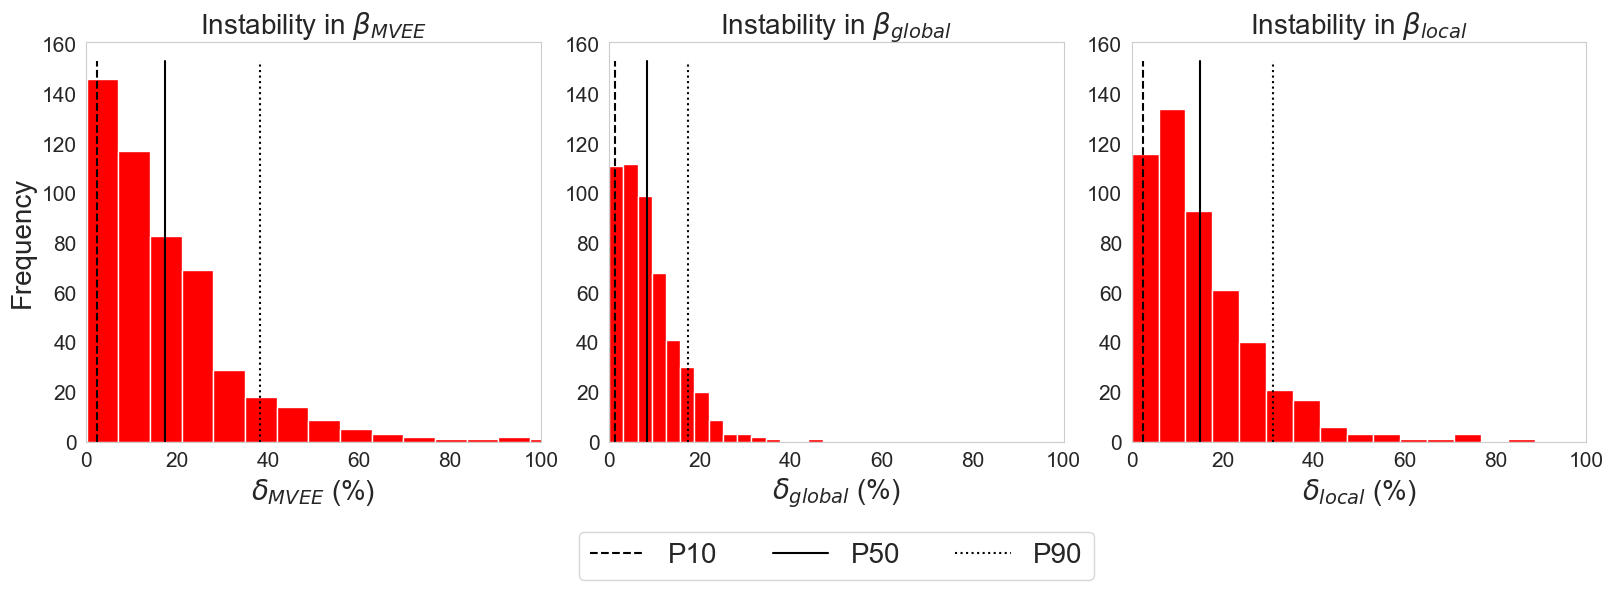

In [188]:
# Find optimal bins for each stats
optimal_bin1 = knuth_bin_width(change_mvee_anis)
optimal_bin2 = knuth_bin_width(change_global_anis)
optimal_bin3 = knuth_bin_width(change_har_anis)

# Compute histogram data
hist_data_1, _ = np.histogram(change_mvee_anis, bins=optimal_bin1)
hist_data_2, _ = np.histogram(change_global_anis, bins=optimal_bin2)
hist_data_3, _ = np.histogram(change_har_anis, bins=optimal_bin3)

# Obtain the maximum frequency from all histogram data since the sample size is same for each metric i.e. 1000 AE realizations
overall_max_freq = max(max(hist_data_1), max(hist_data_2), max(hist_data_3))
overall_max_freq += overall_max_freq * 0.05

# Visualize percentage changes for shape-based statistics
fig, axs = plt.subplots(1, 3, figsize=(10, 4)) #-o #8,4 ?
axs[0].hist(change_mvee_anis, bins=optimal_bin1, color='red', edgecolor='white')
histogram_bounds(ax_or_plt=axs[0], optimal_bin=optimal_bin1, values=change_mvee_anis,weights=np.ones(len(change_mvee_anis)), color='black', max_freq_override=overall_max_freq)
axs[0].set_xlabel(r'$\delta_{MVEE}$ (%)', fontsize= 20)
axs[0].set_ylabel('Frequency', fontsize= 20)
axs[0].set_title("Instability in $\\beta_{MVEE}$", fontsize= 20)
axs[0].tick_params(axis='both', labelsize=15)
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[0].set_xlim([0, 100])  # Set x-axis limits

axs[1].hist(change_global_anis, bins=optimal_bin2, color='red', edgecolor='white')
histogram_bounds(ax_or_plt=axs[1], optimal_bin=optimal_bin2, values=change_global_anis,weights=np.ones(len(change_global_anis)),color='black', max_freq_override=overall_max_freq)
axs[1].set_xlabel(r'$\delta_{global}$ (%)', fontsize= 20)
axs[1].set_title("Instability in $\\beta_{global}$", fontsize= 20)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].tick_params(axis='both', labelsize=15)
axs[1].set_xlim([0, 100])  # Set x-axis limits

axs[2].hist(change_har_anis, bins=optimal_bin3, color='red', edgecolor='white') # based off F1 score computation INSPO!
histogram_bounds(ax_or_plt=axs[2], optimal_bin=optimal_bin, values=change_har_anis,weights=np.ones(len(change_har_anis)),color='black', max_freq_override=overall_max_freq)
axs[2].set_xlabel(r'$\delta_{local}$ (%)', fontsize= 20)
axs[2].set_title("Instability in $\\beta_{local}$", fontsize= 20)
axs[2].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[2].tick_params(axis='both', labelsize=15)
axs[2].set_xlim([0, 100])  # Set x-axis limits

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:3], labels[:3], loc='lower center', bbox_to_anchor=(0.75, -0.08), ncol=3, fontsize=20)

plt.subplots_adjust(left=0.0, bottom=0.3, right=1.5, top=1.3, wspace=0.15, hspace=0.3)
plt.savefig('Modified Instability in Anisotropy-ratio-based Statistics2.tiff', dpi=300, bbox_inches='tight')
plt.show()

In [173]:
# Calculate anisotropy ratio based percentiles measure of stability
percentiles_mvee = np.percentile(change_mvee_anis, [10, 50, 90])
percentiles_global = np.percentile(change_global_anis, [10, 50, 90])
percentiles_har = np.percentile(change_har_anis, [10, 50, 90])

print(f"P10, P50, P90 for δ_MVEE: {percentiles_mvee[0]:.2f}%, {percentiles_mvee[1]:.2f}%, {percentiles_mvee[2]:.2f}%")
print(f"P10, P50, P90 for δ_global: {percentiles_global[0]:.2f}%, {percentiles_global[1]:.2f}%, {percentiles_global[2]:.2f}%")
print(f"P10, P50, P90 for δ_harmonic: {percentiles_har[0]:.2f}%, {percentiles_har[1]:.2f}%, {percentiles_har[2]:.2f}%")

P10, P50, P90 for δ_MVEE: 2.35%, 13.33%, 37.77%
P10, P50, P90 for δ_global: 1.28%, 7.22%, 17.33%
P10, P50, P90 for δ_harmonic: 2.43%, 11.82%, 30.95%


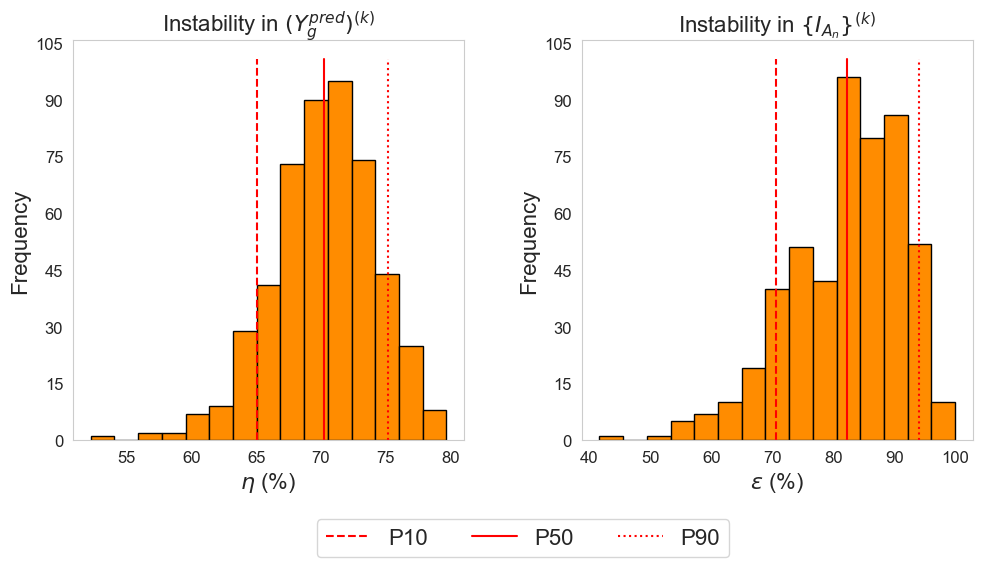

In [191]:
# Find optimal bins for each stats
optimal_bin = knuth_bin_width(change_percentages)
optimal_bin_ = knuth_bin_width(change_anchors)


# Compute histogram data
hist_data_1, _ = np.histogram(change_percentages, bins=optimal_bin)
hist_data_2, _ = np.histogram(change_anchors, bins=optimal_bin_)

# Obtain the maximum frequency from all histogram data since the sample size is same for each metric i.e. 1000 AE realizations
overall_max_freq = max(max(hist_data_1), max(hist_data_2))
overall_max_freq += overall_max_freq * 0.05

# Visualize percentage changes for shape-based statistics
fig, axs = plt.subplots(1, 2, figsize=(6, 4)) #-o #8,4 ?
axs[0].hist(change_percentages, bins=optimal_bin, color='darkorange', edgecolor='black')
histogram_bounds(ax_or_plt=axs[0], optimal_bin=optimal_bin, values=change_percentages,weights=np.ones(len(change_percentages)), color='red', max_freq_override=overall_max_freq)
axs[0].set_xlabel(r'$\eta$ (%)', fontsize= 16)
axs[0].set_ylabel('Frequency', fontsize= 16)
axs[0].set_title("Instability in $(Y_{g}^{pred})^{(k)}$", fontsize= 16)
axs[0].tick_params(axis='both', labelsize=12)
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
# axs[0].set_xlim([0, 100])  # Set x-axis limits

axs[1].hist(change_anchors, bins=optimal_bin_, color='darkorange', edgecolor='black')
histogram_bounds(ax_or_plt=axs[1], optimal_bin=optimal_bin_, values=change_anchors,weights=np.ones(len(change_anchors)), color='red', max_freq_override=overall_max_freq)
axs[1].set_xlabel(r'$\varepsilon$ (%)', fontsize= 16)
axs[1].set_ylabel('Frequency', fontsize= 16)
axs[1].set_title(r'Instability in $\{I_{A_n}\}^{(k)}$', fontsize= 16)
axs[1].tick_params(axis='both', labelsize=12)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
# axs[1].set_xlim([0, 100])  # Set x-axis limits

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:3], labels[:3], loc='lower center', bbox_to_anchor=(0.75, -0.02), ncol=3, fontsize=16)

plt.subplots_adjust(left=0.0, bottom=0.3, right=1.5, top=1.3, wspace=0.30, hspace=0.3)
plt.savefig('Modified Instability in Shape-based Statistics.tiff', dpi=300, bbox_inches='tight')
plt.show()

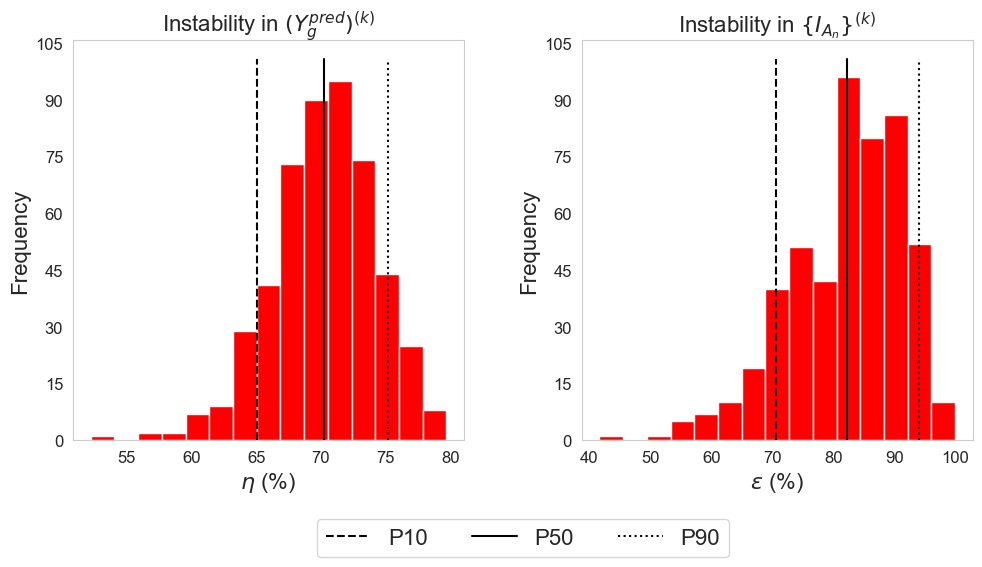

In [181]:
# Find optimal bins for each stats
optimal_bin = knuth_bin_width(change_percentages)
optimal_bin_ = knuth_bin_width(change_anchors)


# Compute histogram data
hist_data_1, _ = np.histogram(change_percentages, bins=optimal_bin)
hist_data_2, _ = np.histogram(change_anchors, bins=optimal_bin_)

# Obtain the maximum frequency from all histogram data since the sample size is same for each metric i.e. 1000 AE realizations
overall_max_freq = max(max(hist_data_1), max(hist_data_2))
overall_max_freq += overall_max_freq * 0.05

# Visualize percentage changes for shape-based statistics
fig, axs = plt.subplots(1, 2, figsize=(6, 4)) #-o #8,4 ?
axs[0].hist(change_percentages, bins=optimal_bin, color='red', edgecolor='white')
histogram_bounds(ax_or_plt=axs[0], optimal_bin=optimal_bin, values=change_percentages,weights=np.ones(len(change_percentages)), color='black', max_freq_override=overall_max_freq)
axs[0].set_xlabel(r'$\eta$ (%)', fontsize= 16)
axs[0].set_ylabel('Frequency', fontsize= 16)
axs[0].set_title("Instability in $(Y_{g}^{pred})^{(k)}$", fontsize= 16)
axs[0].tick_params(axis='both', labelsize=12)
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].hist(change_anchors, bins=optimal_bin_, color='red', edgecolor='white')
histogram_bounds(ax_or_plt=axs[1], optimal_bin=optimal_bin_, values=change_anchors,weights=np.ones(len(change_anchors)), color='black', max_freq_override=overall_max_freq)
axs[1].set_xlabel(r'$\varepsilon$ (%)', fontsize= 16)
axs[1].set_ylabel('Frequency', fontsize= 16)
axs[1].set_title(r'Instability in $\{I_{A_n}\}^{(k)}$', fontsize= 16)
axs[1].tick_params(axis='both', labelsize=12)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:3], labels[:3], loc='lower center', bbox_to_anchor=(0.75, -0.02), ncol=3, fontsize=16)

plt.subplots_adjust(left=0.0, bottom=0.3, right=1.5, top=1.3, wspace=0.30, hspace=0.3)
plt.savefig('Modified Instability in Shape-based Statistics2.tiff', dpi=300, bbox_inches='tight')
plt.show()

In [174]:
# Calculate percentiles for change_percentages
percentiles_percentages = np.percentile(change_percentages, [10, 50, 90])

# Calculate percentiles for change_anchors
percentiles_anchors = np.percentile(change_anchors, [10, 50, 90])

print(f"P10, P50, P90 for η (%): {percentiles_percentages[0]:.2f}%, {percentiles_percentages[1]:.2f}%, {percentiles_percentages[2]:.2f}%")
print(f"P10, P50, P90 for ε (%): {percentiles_anchors[0]:.2f}%, {percentiles_anchors[1]:.2f}%, {percentiles_anchors[2]:.2f}%")

P10, P50, P90 for η (%): 65.09%, 70.45%, 75.20%
P10, P50, P90 for ε (%): 70.59%, 83.33%, 94.12%


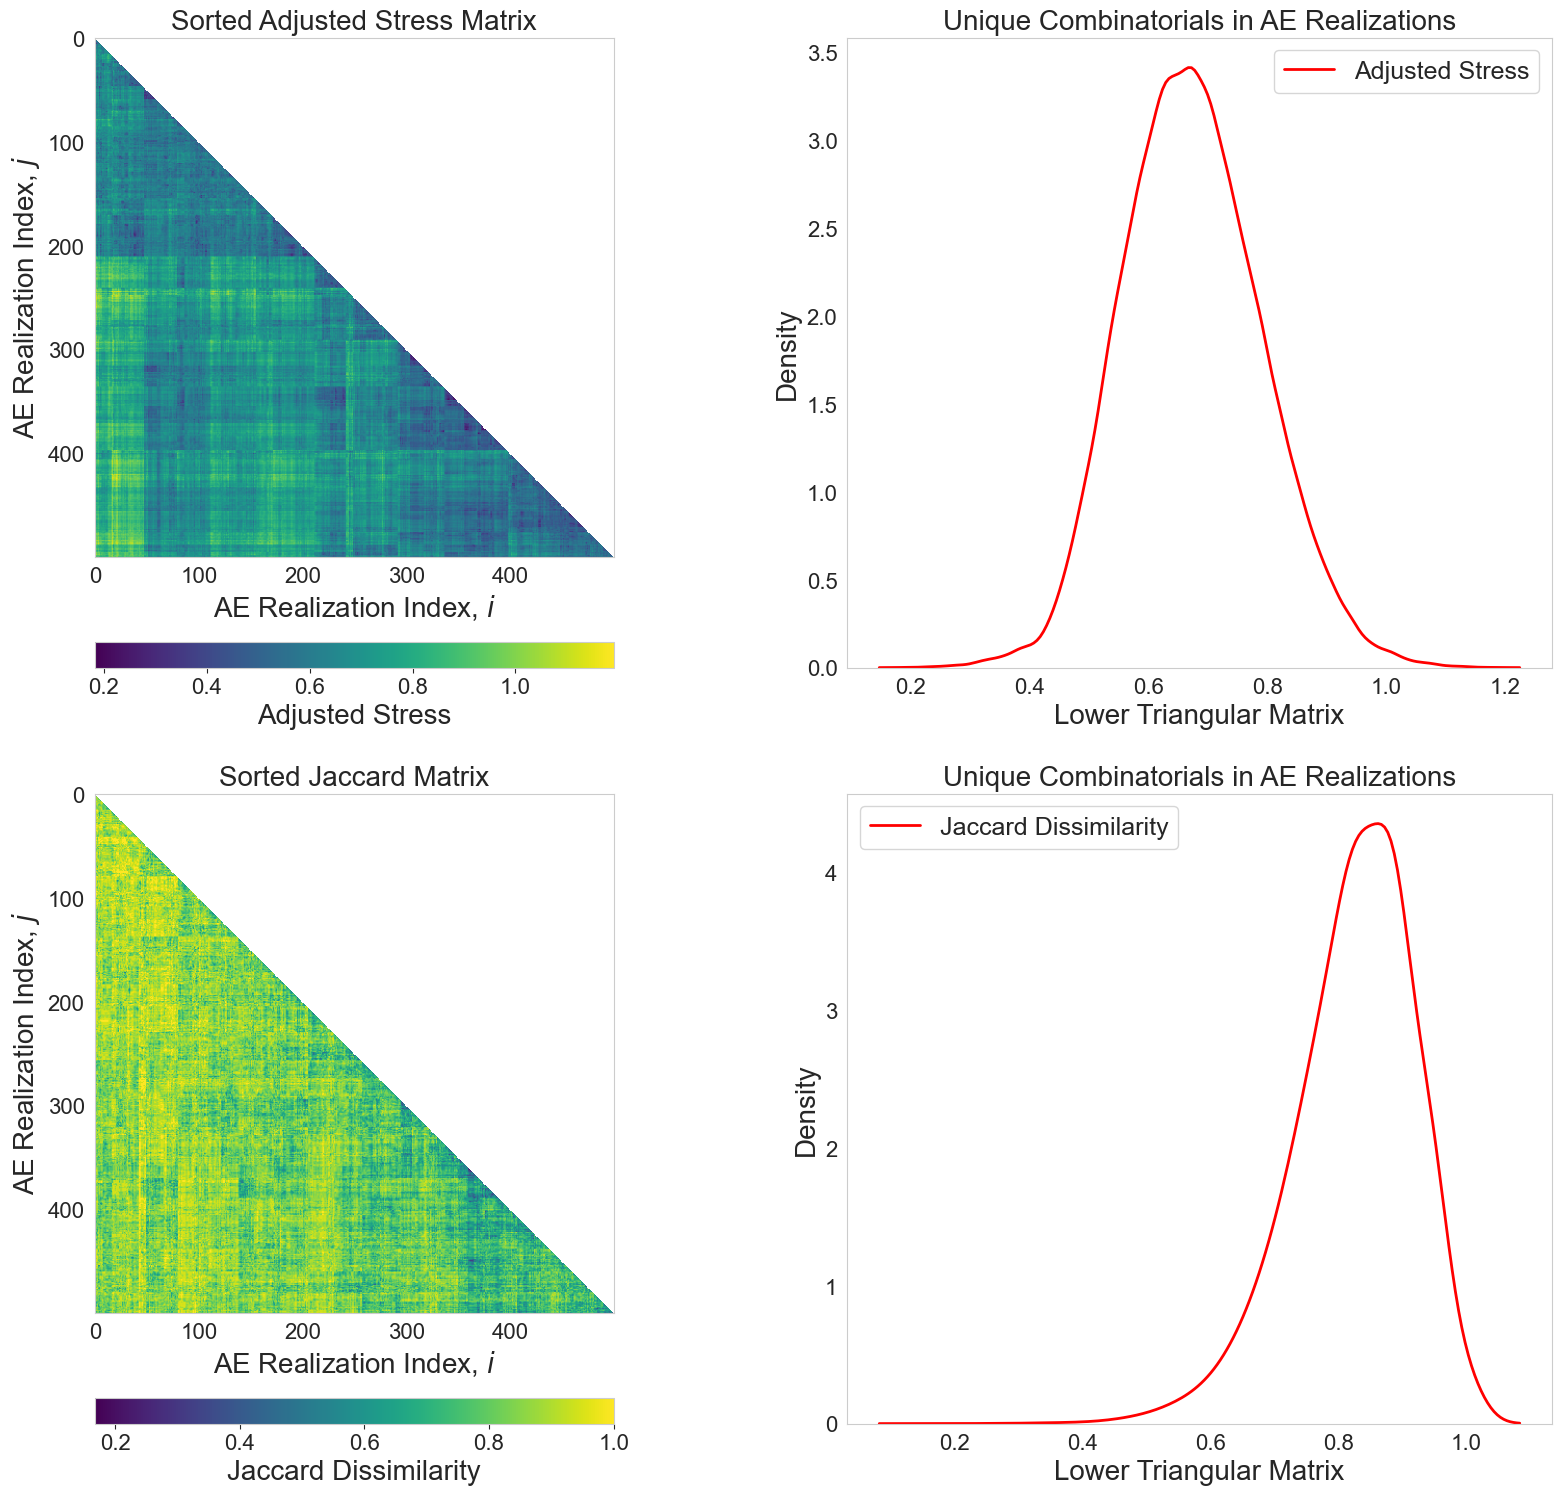

Mode for adjusted stress: 0.6674
Mode for Jaccard dissimilarity: 0.8625


In [187]:
# Compute and Visualize stress measures
ordered_dist_mat1, res_order1, res_linkage1 = compute_serial_matrix(adjusted_stress_matrix,"ward")

# Extract the lower triangular matrix for the sorted stress matrices excluding diagonal and visualize via kde
lower_triangle1 = np.tril(ordered_dist_mat1, k=-1) # Adjusted stress
upper_triangle_mask = np.triu(np.ones(ordered_dist_mat1.shape), k=0).astype(bool)
lower_triangle1[upper_triangle_mask] = np.nan
flatten_data1 = lower_triangle1[~np.isnan(lower_triangle1)]

# Compute and Visualize Jaccard similarity measures
ordered_dist_mat2, res_order2, res_linkage2 = compute_serial_matrix(similarity_matrix,"ward")

# Extract the lower triangular matrix for the sorted stress matrices excluding diagonal and visualize via kde
lower_triangle2 = np.tril(ordered_dist_mat2, k=-1) # Jaccard similarity
upper_triangle_mask = np.triu(np.ones(ordered_dist_mat2.shape), k=0).astype(bool)
lower_triangle2[upper_triangle_mask] = np.nan
flatten_data2 = lower_triangle2[~np.isnan(lower_triangle2)]

# make jaccard dissimilarity i.e., 1-similarity 
lower_triangle2 = 1-lower_triangle2
flatten_data2 = lower_triangle2[~np.isnan(lower_triangle2)]

# Save stress and jaccard values to numpy arrays
np.save('jaccard_array_corr_0.npy', flatten_data2)
# np.save('jaccard_array_wine.npy', flatten_data2)
# np.save('jaccard_array_corr_1.npy', flatten_data2)

np.save('stress_array_corr_0.npy', flatten_data1)
# np.save('stress_array_wine.npy', flatten_data1)
# np.save('stress_array_corr_1.npy', flatten_data1)

fig, axs = plt.subplots(2, 2, figsize=(20, 18)) # orange and purple
# Sorted Adjusted Stress - lower triangle matrix excluding diagonal
im1 = axs[0, 0].imshow(lower_triangle1, cmap="viridis")
axs[0, 0].set_title("Sorted Adjusted Stress Matrix", size=20)
axs[0, 0].set_xlabel("AE Realization Index, $i$", size=20)
axs[0, 0].set_ylabel("AE Realization Index, $j$", size=20)
axs[0, 0].tick_params(axis='both', which='major', labelsize=16)
# Aesthetics
divider = make_axes_locatable(axs[0, 0])
cax1 = divider.append_axes("bottom", size="5%", pad=0.85)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.25)
cbar1.set_label('Adjusted Stress', size=20)
cbar1.ax.tick_params(labelsize=16)

# KDE of lower triangular matrix of adjusted stress excluding the diagonal
sns.kdeplot(flatten_data1, ax=axs[0, 1], color='red', label='Adjusted Stress', linewidth=2)
axs[0, 1].set_title("Unique Combinatorials in AE Realizations", size=20) # MIDE
axs[0, 1].set_xlabel('Lower Triangular Matrix', fontsize=20)
axs[0, 1].set_ylabel('Density', fontsize=20)
axs[0, 1].tick_params(labelsize=16)
axs[0, 1].legend(fontsize=18)

# Sorted Adjusted Jaccard - lower triangle matrix excluding diagonal
im1 = axs[1, 0].imshow(lower_triangle2, cmap="viridis")
axs[1, 0].set_title("Sorted Jaccard Matrix", size=20)
axs[1, 0].set_xlabel("AE Realization Index, $i$", size=20)
axs[1, 0].set_ylabel("AE Realization Index, $j$", size=20)
axs[1, 0].tick_params(axis='both', which='major', labelsize=16)
# Aesthetics
divider = make_axes_locatable(axs[1, 0])
cax1 = divider.append_axes("bottom", size="5%", pad=0.85)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.25)
cbar1.set_label('Jaccard Dissimilarity', size=20)
cbar1.ax.tick_params(labelsize=16)

# KDE of lower triangular matrix of Jaccard excluding the diagonal
sns.kdeplot(flatten_data2, ax=axs[1, 1], bw_method=0.3, color='red', label='Jaccard Dissimilarity', linewidth=2)
axs[1, 1].set_title("Unique Combinatorials in AE Realizations", size=20) # MIDE
axs[1, 1].set_xlabel('Lower Triangular Matrix', fontsize=20)
axs[1, 1].set_ylabel('Density', fontsize=20)
axs[1, 1].tick_params(labelsize=16)
axs[1, 1].legend(fontsize=18)

# Customization
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig('Combined Stress and Jaccard Analysis.tiff', dpi=300, bbox_inches='tight')
plt.show()

# Assuming axs[0, 1] contains the KDE plot for adjusted stress
line_stress = axs[0, 1].get_lines()[0]  # Get the first (and likely only) line in the plot
x_data_stress, y_data_stress = line_stress.get_data()
mode_stress = x_data_stress[np.argmax(y_data_stress)]

# Assuming axs[1, 1] contains the KDE plot for Jaccard similarity
line_jaccard = axs[1, 1].get_lines()[0]  # Get the first (and likely only) line in the plot
x_data_jaccard, y_data_jaccard = line_jaccard.get_data()
mode_jaccard = x_data_jaccard[np.argmax(y_data_jaccard)]

# Print the mode values
print(f"Mode for adjusted stress: {mode_stress:.4f}")
print(f"Mode for Jaccard dissimilarity: {mode_jaccard:.4f}")

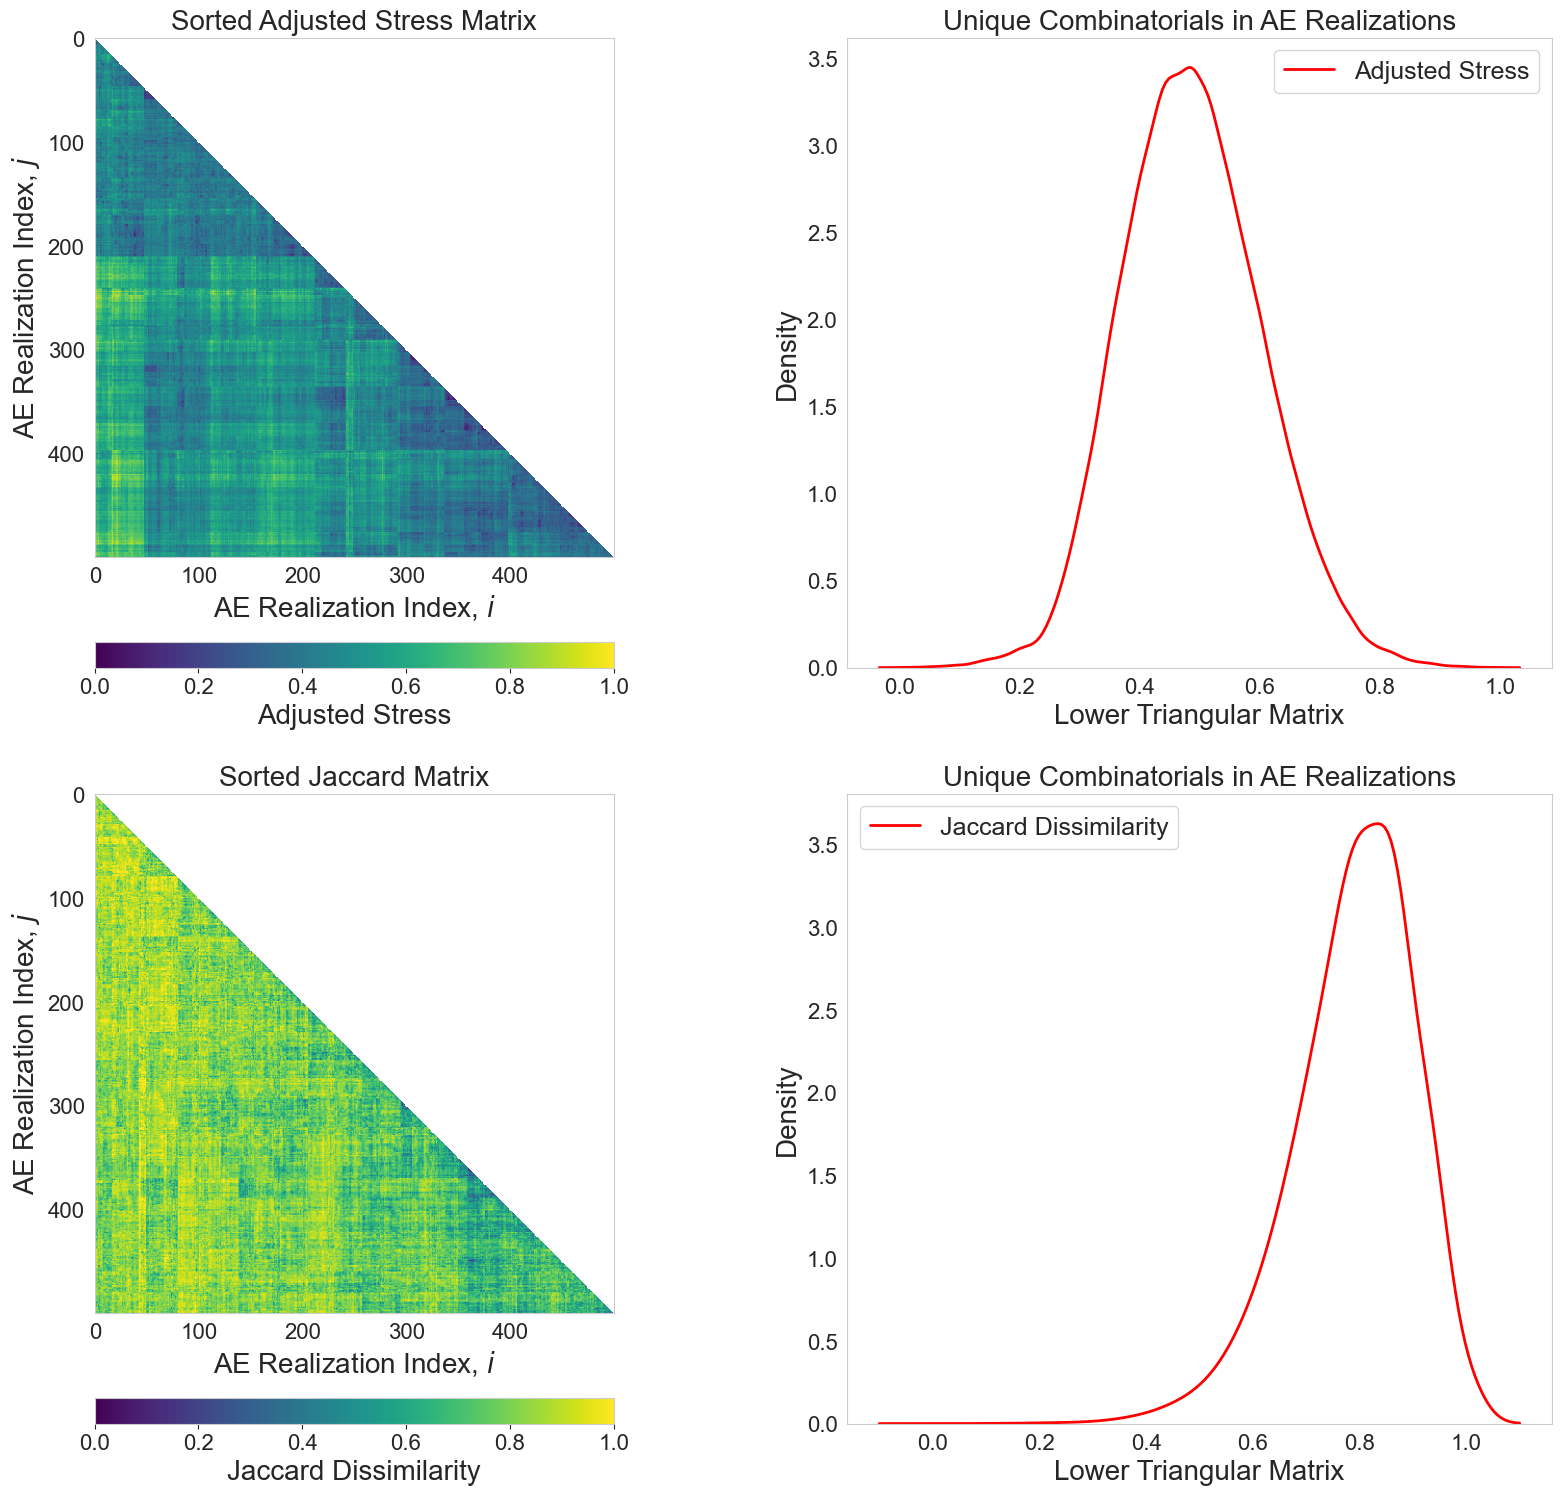

Mode for adjusted stress: 0.4812
Mode for Jaccard dissimilarity: 0.8350


In [199]:
# normalized adjusted stress
lower_triangle1_normalized = (lower_triangle1 - np.nanmin(lower_triangle1)) / (np.nanmax(lower_triangle1) - np.nanmin(lower_triangle1))
flatten_data1_normalized = (flatten_data1 - np.min(flatten_data1)) / (np.max(flatten_data1) - np.min(flatten_data1))

# normalized jaccard
lower_triangle2_normalized = (lower_triangle2 - np.nanmin(lower_triangle2)) / (np.nanmax(lower_triangle2) - np.nanmin(lower_triangle2))
flatten_data2_normalized = (flatten_data2 - np.min(flatten_data2)) / (np.max(flatten_data2) - np.min(flatten_data2))

# Save stress and jaccard values to numpy arrays
np.save('jaccard_array_corr_0_norm.npy', flatten_data2_normalized)
# np.save('jaccard_array_wine.npy', flatten_data2)
# np.save('jaccard_array_corr_1.npy', flatten_data2)

np.save('stress_array_corr_0_norm.npy', flatten_data1_normalized)
# np.save('stress_array_wine.npy', flatten_data1)
# np.save('stress_array_corr_1.npy', flatten_data1)

fig, axs = plt.subplots(2, 2, figsize=(20, 18)) # orange and purple
# Sorted Adjusted Stress - lower triangle matrix excluding diagonal
im1 = axs[0, 0].imshow(lower_triangle1_normalized, cmap="viridis", vmin=0, vmax=1)
axs[0, 0].set_title("Sorted Adjusted Stress Matrix", size=20)
axs[0, 0].set_xlabel("AE Realization Index, $i$", size=20)
axs[0, 0].set_ylabel("AE Realization Index, $j$", size=20)
axs[0, 0].tick_params(axis='both', which='major', labelsize=16)
# Aesthetics
divider = make_axes_locatable(axs[0, 0])
cax1 = divider.append_axes("bottom", size="5%", pad=0.85)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.25)
cbar1.set_label('Adjusted Stress', size=20)
cbar1.ax.tick_params(labelsize=16)

# KDE of lower triangular matrix of adjusted stress excluding the diagonal
sns.kdeplot(flatten_data1_normalized, ax=axs[0, 1], color='red', label='Adjusted Stress', linewidth=2)
axs[0, 1].set_title("Unique Combinatorials in AE Realizations", size=20) # MIDE
axs[0, 1].set_xlabel('Lower Triangular Matrix', fontsize=20)
axs[0, 1].set_ylabel('Density', fontsize=20)
axs[0, 1].tick_params(labelsize=16)
axs[0, 1].legend(fontsize=18)

# Sorted Adjusted Jaccard - lower triangle matrix excluding diagonal
im1 = axs[1, 0].imshow(lower_triangle2_normalized, cmap="viridis", vmin=0, vmax=1)
axs[1, 0].set_title("Sorted Jaccard Matrix", size=20)
axs[1, 0].set_xlabel("AE Realization Index, $i$", size=20)
axs[1, 0].set_ylabel("AE Realization Index, $j$", size=20)
axs[1, 0].tick_params(axis='both', which='major', labelsize=16)
# Aesthetics
divider = make_axes_locatable(axs[1, 0])
cax1 = divider.append_axes("bottom", size="5%", pad=0.85)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.25)
cbar1.set_label('Jaccard Dissimilarity', size=20)
cbar1.ax.tick_params(labelsize=16)

# KDE of lower triangular matrix of Jaccard excluding the diagonal
sns.kdeplot(flatten_data2_normalized, ax=axs[1, 1], bw_method=0.3, color='red', label='Jaccard Dissimilarity', linewidth=2)
axs[1, 1].set_title("Unique Combinatorials in AE Realizations", size=20) # MIDE
axs[1, 1].set_xlabel('Lower Triangular Matrix', fontsize=20)
axs[1, 1].set_ylabel('Density', fontsize=20)
axs[1, 1].tick_params(labelsize=16) 
axs[1, 1].legend(fontsize=18)

# Customization
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig('Combined Stress and Jaccard Analysis v2.tiff', dpi=300, bbox_inches='tight')
plt.show()

# Assuming axs[0, 1] contains the KDE plot for adjusted stress
line_stress = axs[0, 1].get_lines()[0]  # Get the first (and likely only) line in the plot
x_data_stress, y_data_stress = line_stress.get_data()
mode_stress = x_data_stress[np.argmax(y_data_stress)]

# Assuming axs[1, 1] contains the KDE plot for Jaccard similarity
line_jaccard = axs[1, 1].get_lines()[0]  # Get the first (and likely only) line in the plot
x_data_jaccard, y_data_jaccard = line_jaccard.get_data()
mode_jaccard = x_data_jaccard[np.argmax(y_data_jaccard)]

# Print the mode values
print(f"Mode for adjusted stress: {mode_stress:.4f}")
print(f"Mode for Jaccard dissimilarity: {mode_jaccard:.4f}")

In [ ]:
# # Loop through each realization and plot local anisotropy
# with h5py.File(hdf5_file, 'r') as f:
#     for i in range(500):  # Assuming there are 500 realizations
#         key = f'embedding_realizations_{i}'
#         if key in f:
#             example_embedding = f[key][:]
#             global_anis, local_anis, harmonic_anis = compute_anisotropy(array_2d=example_embedding, type='local', plotter=True)
#         else:
#             print(f"Key '{key}' not found in the HDF5 file.")